In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import shapely
import geopandas as gpd
import folium
from pyproj import Proj, Transformer
import seaborn as sns


In [2]:
#open a laz file
path = "C:\Users\Asus\Desktop\Projets_info\LIDAR\LIDARHD_1-0_LAZ_PM-0914_6459-2021\Semis_2021_0914_6459_LA93_IGN69.laz"
import laspy
lid = laspy.read(path)

In [3]:
gredf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lid.x, lid.y, lid.z))

In [4]:
gredf.iloc[0].geometry.x

914000.05

In [5]:
gredf.shape

(27492689, 1)

In [7]:
sampledf = gredf.sample(1000)

sampledf.geometry.x.describe()

count      1000.000000
mean     914509.078940
std         295.226709
min      914000.300000
25%      914240.210000
50%      914535.795000
75%      914767.872500
max      914998.470000
dtype: float64

In [8]:
middlex = sampledf.geometry.x.mean()
middley = sampledf.geometry.y.mean()
decilez = sampledf.geometry.z.mean()

In [9]:
southwest = gredf[(gredf.geometry.x < middlex) & (gredf.geometry.y < middley)]

In [31]:
cutoff = 219
buildings = southwest[southwest.geometry.z > cutoff]

In [16]:
def gps_to_lamb(P):
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:2154")
    x2,y2 = transformer.transform(P[0],P[1])
    return [x2,y2]

def lamb_to_gps(P):
    transformer = Transformer.from_crs("EPSG:2154", "EPSG:4326")
    x2,y2 = transformer.transform(P[0],P[1])
    return [x2,y2]

def add_point(P, m):
    folium.Marker(location=gps_to_lamb(P), popup='JDV', icon=folium.Icon(color='red')).add_to(m)

In [32]:
m = folium.Map(location=[45.188, 5.725], zoom_start=16)

for i in buildings.sample(100).index:
    folium.Marker(lamb_to_gps([buildings.loc[i].geometry.x, buildings.loc[i].geometry.y]), popup=buildings.loc[i].geometry.z).add_to(m)
    
m

In [33]:
bigsamp = buildings.sample(20000)

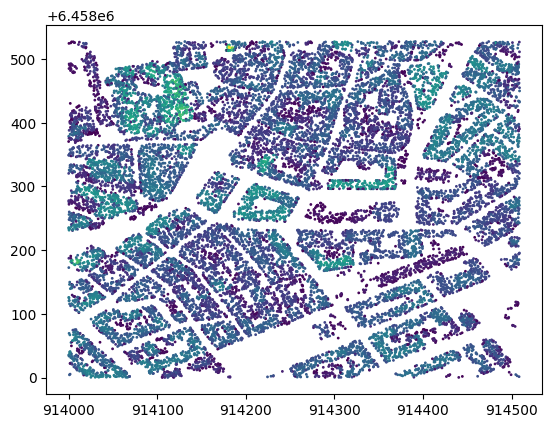

In [66]:
plt.scatter(bigsamp.geometry.x, bigsamp.geometry.y, c=bigsamp.geometry.z, cmap='viridis', s = 1)

In [60]:
from sklearn.cluster import DBSCAN
X = pd.DataFrame({'x':bigsamp.geometry.x, 'y':bigsamp.geometry.y})
cluster = DBSCAN(eps=7, min_samples=15).fit(X)
X["label"] = cluster.labels_

In [61]:
print(max(cluster.labels_))

106


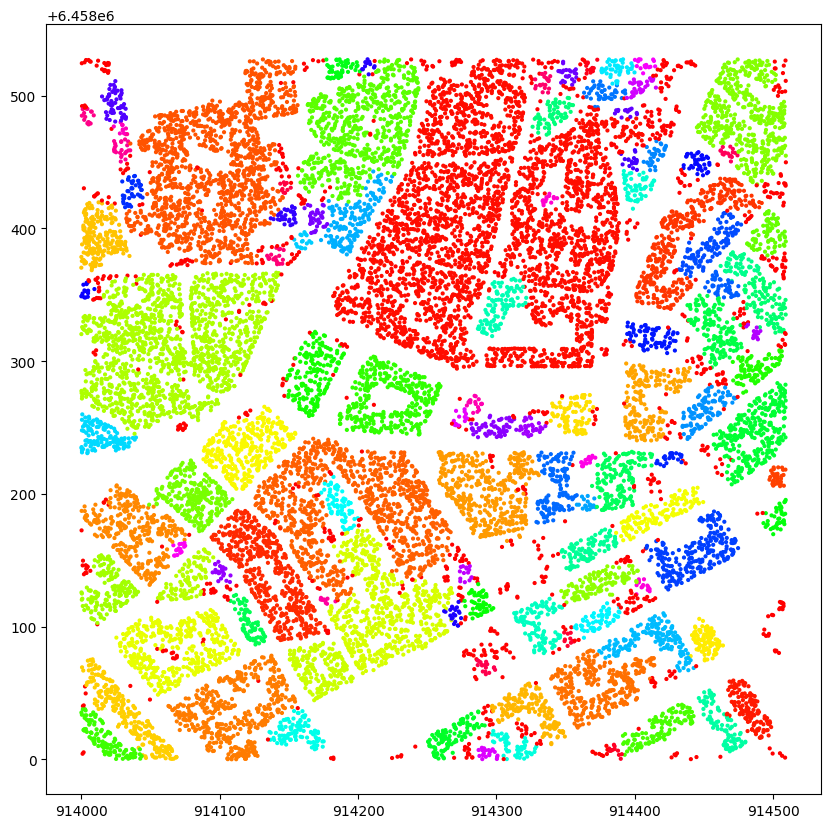

In [67]:
plt.scatter(X.x, X.y, c=X.label, cmap='hsv', s = 4)
plt.gcf().set_size_inches(10,10)

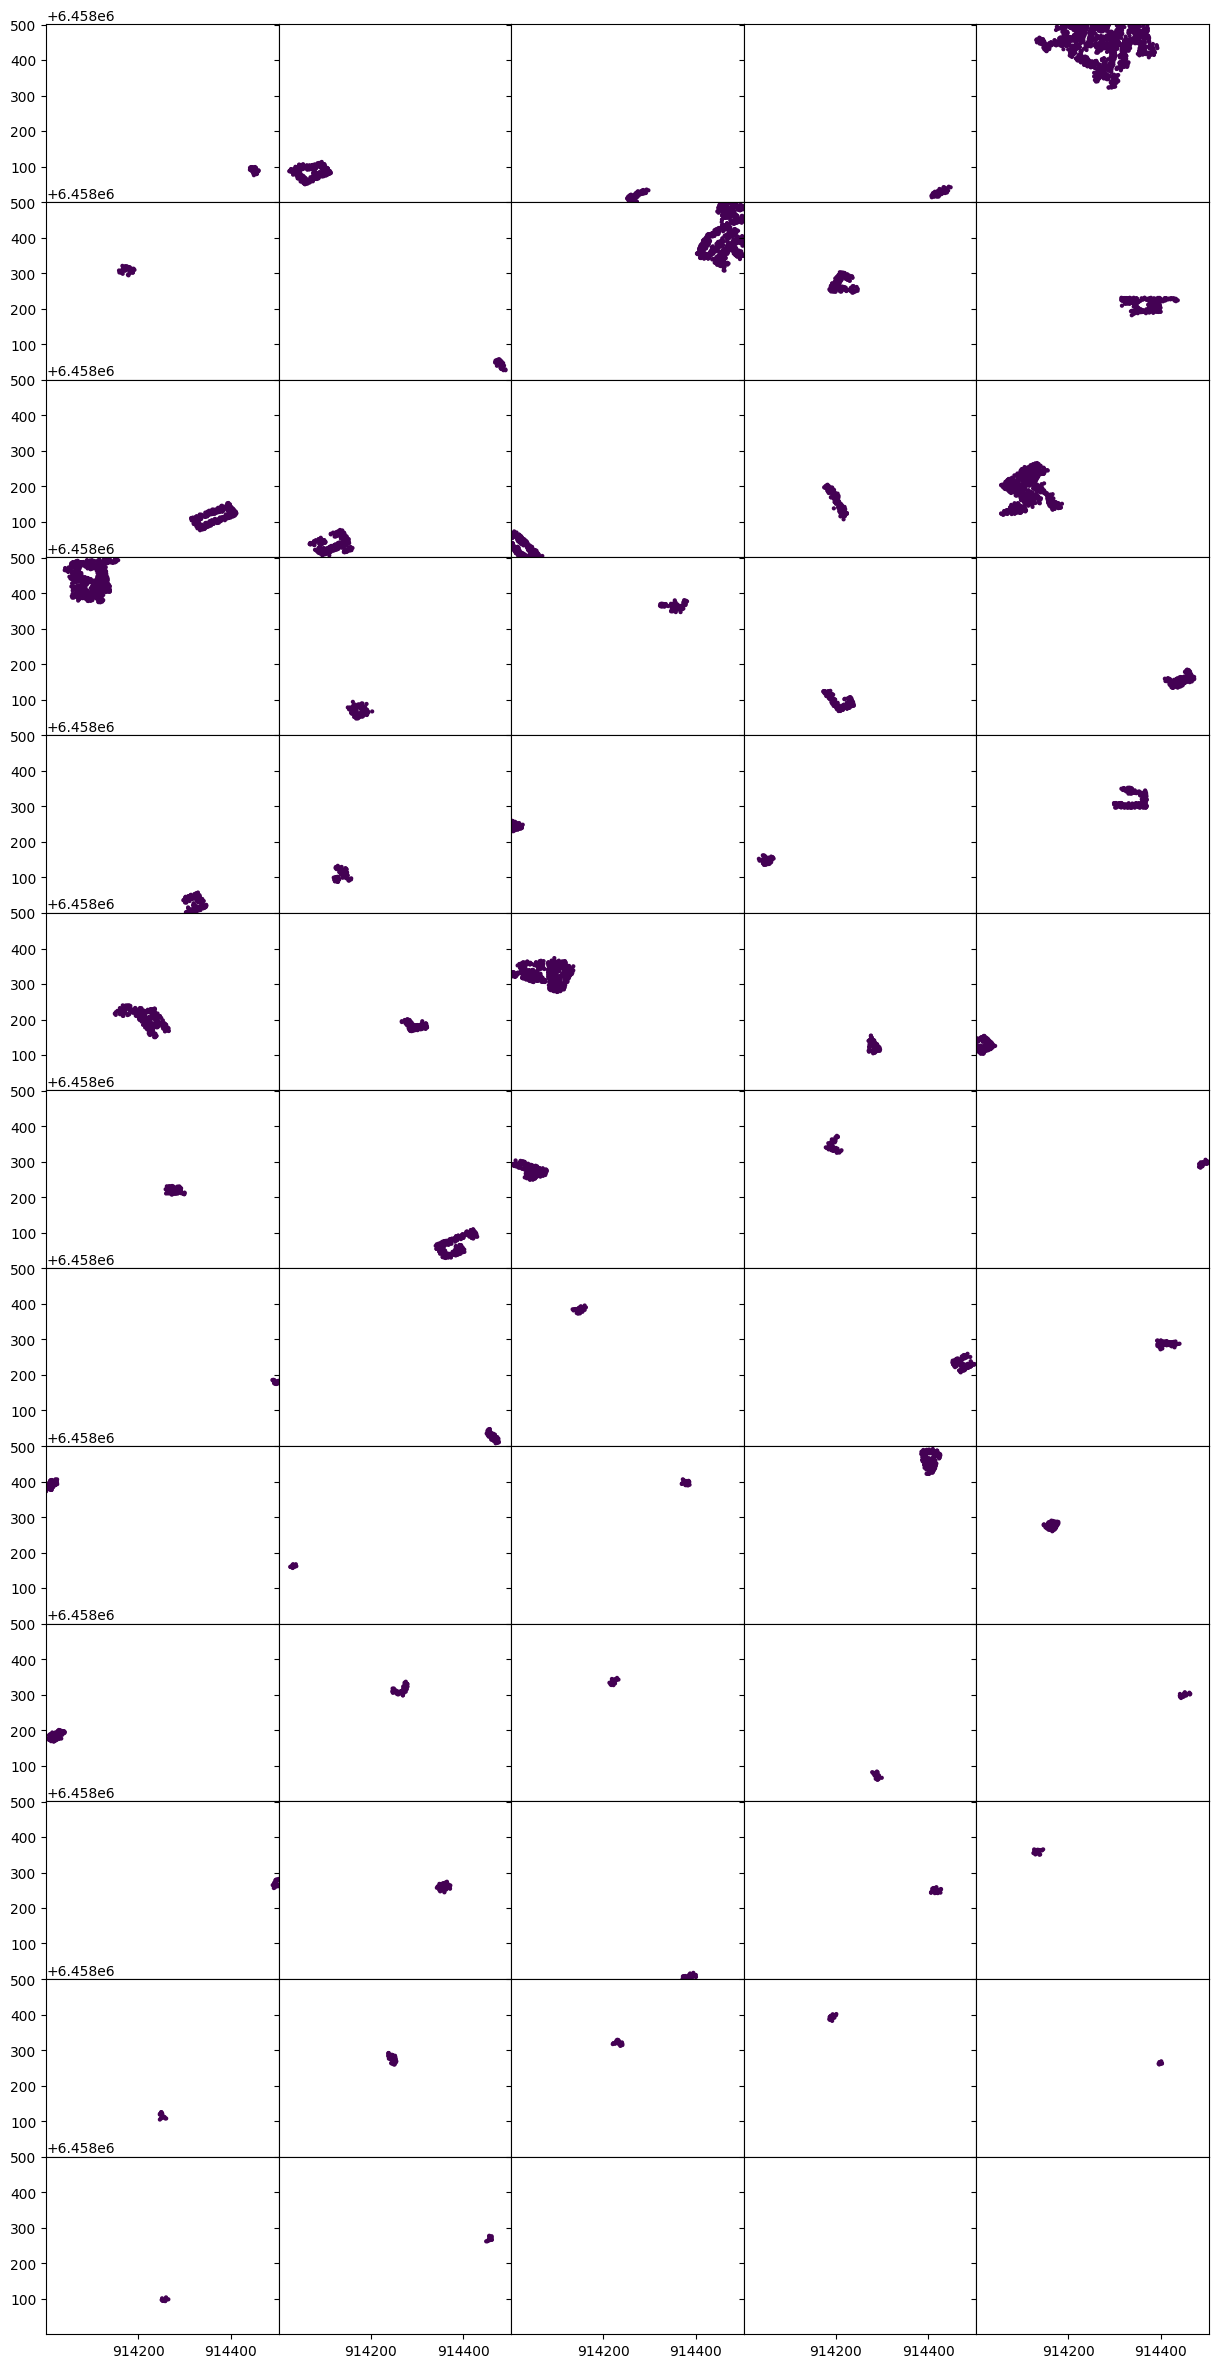

In [92]:
N_clusters = len(set(cluster.labels_)) - (1 if -1 in cluster.labels_ else 0)

k = 5
fig, ax = plt.subplots(N_clusters//k+1, k, figsize=(15, 30), sharex=True, sharey=True)
for i in range(N_clusters):
    ax[i//k][i%k].set_xlim([X.x.min(), X.x.max()])
    ax[i//k][i%k].set_ylim([X.y.min(), X.y.max()])
    ax[i//k][i%k].scatter(X[X.label == i].x, X[X.label == i].y, c=X[X.label == i].label, cmap='viridis', s = 4)
    
plt.subplots_adjust(hspace=.0, wspace=.0)

In [ ]:
import open3d as o3d

